## Sustainability Challenge - Summary Notebook

This notebook can be ran to achieve my second place score.

I always start these challenges by creating very simple models initially, and then building more complex and refined approaches as my understanding of the problem (hopefully) improves. This means that I end up creating and discarding whole notebooks and/or chunks of code, and often write code that starts of being clean and well organised, but as it develops it can become quite messy and certainly not follow best practice – as the attached notebook will illustrate. 

My background is as a mechanical engineer, and so my approach is often influenced by the need to always consider the physics of a problem (the physical laws that might govern how things should interact) and also to recognise that there may be external noise factors that can affect the data, some of which may not be readily modelled from the data (random human errors, for example).

The challenge is essentially in three parts: forecasting the India yields, forecasting the US yields and finally forecasting the price.
The India forecast was the most challenging. I tried many different ways and spent a lot of time to develop what I thought would lead to a good result, but found I could not improve on what I think is an overly simple approach (that also includes some modelling errors). 
The ‘best’ model was a simple XGBoost regressor, with only rainfall substitutions for NaN and some feature engineering and post-processing around the yield calculations, all centred on the decimal point position (powers of 10). This model shouldn’t have worked so well – I developed much ‘better’ models that couldn’t out perform this, but didn’t have the time to take these much further.  This is also the area where I think there could still be some significant improvements made. I think the results here are highly influenced by the data quality, which I suspect gets better in the last few years of the dataset, and which would allow more conventionally 'nice' models to work better.

The approaches to the US yield and price forecasts are much more conventional, and I think I am much happier with these. The US data lent itself well to  a simple deep learning model, and price forecasting to linear regression, based on current and prior year data.



First import all the dependencies and data

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import numpy as np
from xgboost import XGBRFRegressor, XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from more_itertools import locate

In [196]:
# Load the data
india_train = pd.read_csv("India_train.csv")
india_test = pd.read_csv("India_test.csv")
usa_train = pd.read_csv("USA_train.csv")
usa_test = pd.read_csv("USA_test.csv")
soil_rainfall = pd.read_csv("India_soil_rainfall_30years.csv")
commodity = pd.read_csv("USA_Commodity_prices.csv")
submission = pd.read_csv("submission.csv")

Make some working copies and fix datatypes etc.

In [197]:
i_train = india_train.copy()
i_test = india_test.copy()
u_train = usa_train.copy()
u_test = usa_test.copy()

u_train['Planted (1000 Acres)']= u_train['Planted (1000 Acres)'].str.replace(',','').astype('float')
u_train['Harvested (1000 Acres)']= u_train['Harvested (1000 Acres)'].str.replace(',','').astype('float')
u_test['Planted (1000 Acres)']= u_test['Planted (1000 Acres)'].str.replace(',','').astype('float')
u_test['Harvested (1000 Acres)']= u_test['Harvested (1000 Acres)'].str.replace(',','').astype('float')

i_train = i_train.astype(dtype = 'float', errors='ignore')
i_test = i_test.astype(dtype = 'float', errors='ignore')
u_train = u_train.astype(dtype = 'float', errors='ignore')
u_test = u_test.astype(dtype = 'float', errors='ignore') 

## Explore data

You can see that the units for yield between the US and India datasets are expressed in different units. It might be informative to express them in the same units, so that comparisons can be made. <br>
You can also see tha the India data contains columns for yield, as well as production and area. As yield should just be the division (correcting the units) of production by area, this can be calculated and compared

In [198]:
i_train['yield kg per ha'] = i_train['COTTON PRODUCTION (1000 tons)'] / i_train['COTTON AREA (1000 ha)'] *1000
i_train['yield kg per ha']=i_train['yield kg per ha'].replace([np.inf, -np.inf], np.nan)
# i_test['yield kg per ha'] = i_test['COTTON PRODUCTION (1000 tons)'] / i_test['COTTON AREA (1000 ha)'] *1000
# i_test['yield kg per ha']=i_test['yield kg per ha'].replace([np.inf, -np.inf], np.nan)
u_train['yield kg per ha'] = u_train['Yield (Pounds/ Harvested Area)'] / 2.2046 * 2.407105 
u_train['yield kg per ha']=u_train['yield kg per ha'].replace([np.inf, -np.inf], np.nan)
#u_train['production 1000 tonnes'] = u_train['Harvested (1000 Acres)'] * u_train['Yield (Pounds/ Harvested Area)'] / 2.2046 /1000 


A simple line plot of the yields per year highlights significant differences. <br>
It would be reasonable to expect that for India the calculated and reported values would be the same, and as we are likely to be growing similar crops, the difference between the US and India yields would not be so large  

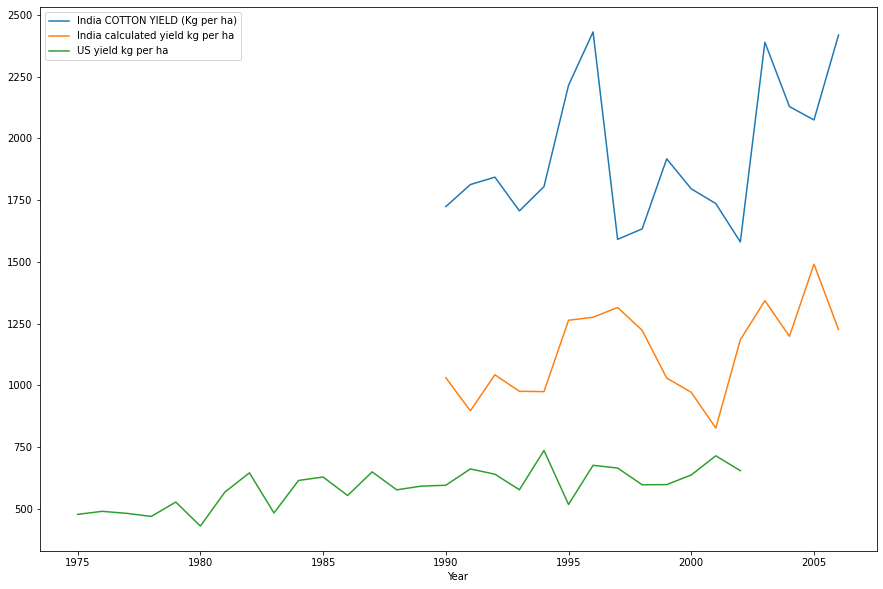

In [199]:
fig, ax = plt.subplots(1,1,figsize=(15,10))
i_train.groupby('Year')['COTTON YIELD (Kg per ha)'].mean().plot(ax=ax, label = 'India COTTON YIELD (Kg per ha)')
i_train.groupby('Year')['yield kg per ha'].mean().plot(ax=ax, label = 'India calculated yield kg per ha')
u_train.groupby('Year')['yield kg per ha'].mean().plot(ax=ax, label = 'US yield kg per ha')
ax.legend()

Let's explore the US data a little more.<br>
A quick histogram of the yield data shows something that looks like a normal distribution, but with a significant number of results higher than expected - possibly two distributions?

<AxesSubplot:>

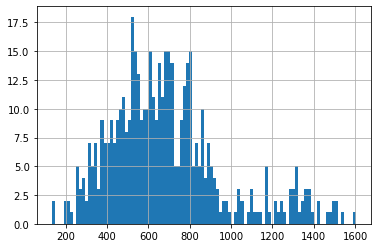

In [200]:
u_train[u_train['yield kg per ha']>0]['yield kg per ha'].hist(bins = 100)

We can take a look at the yields per state and see if this highlights anything significant

<AxesSubplot:xlabel='State', ylabel='yield kg per ha'>

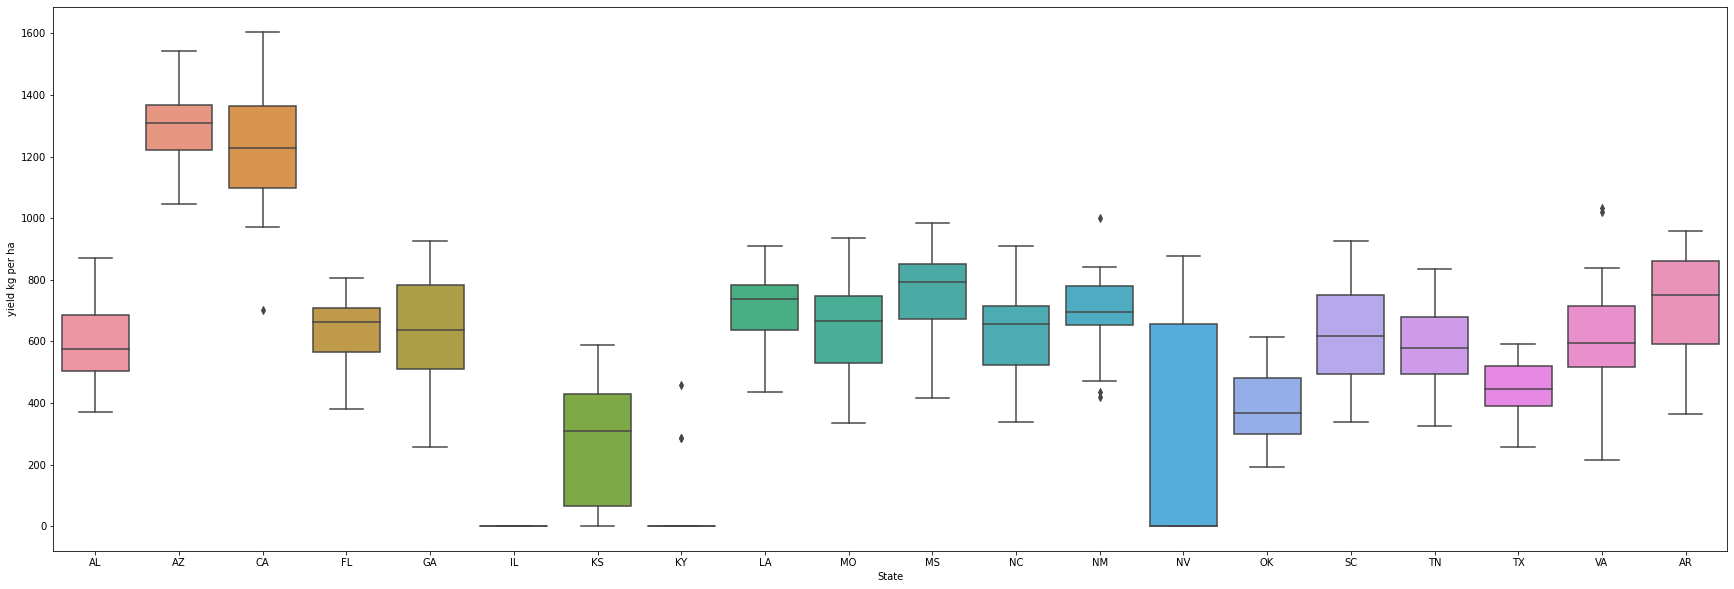

In [201]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
sns.boxplot(data = u_train, x ='State', y = 'yield kg per ha')

Removing AZ and CA from the histogram gives the expected distribution. This is a strong indicator that these two states should be suitably encoded in any predictive model

<AxesSubplot:>

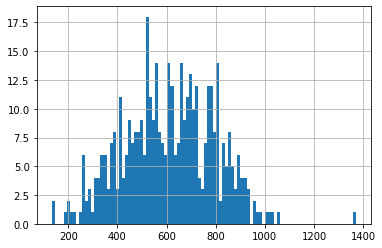

In [202]:
u_train[(~u_train['State'].isin(['CA','AZ'])) & (u_train['yield kg per ha']>0)]['yield kg per ha'].hist(bins = 100)

Now look at the India data. First look at a sample district

In [203]:
i_states = i_train['State Name'].unique()
i_dists = i_train['Dist Name'].unique()
temp_cols = ['Year','State Name', 'Dist Name','COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)',
             'COTTON YIELD (Kg per ha)','yield kg per ha']
i_train[i_train['Dist Name']==i_dists[0]].loc[:,temp_cols]

,Year,State Name,Dist Name,COTTON AREA (1000 ha),COTTON PRODUCTION (1000 tons),COTTON YIELD (Kg per ha),yield kg per ha
0,1990.0,Andhra Pradesh,Srikakulam,0.0,0.0,0.0,NaN
270,1991.0,Andhra Pradesh,Srikakulam,0.0,0.0,0.0,NaN
540,1992.0,Andhra Pradesh,Srikakulam,3.0,2.0,5003.0,666.666667
819,1993.0,Andhra Pradesh,Srikakulam,0.0,20.0,0.0,NaN
1098,1994.0,Andhra Pradesh,Srikakulam,0.0,19.0,0.0,NaN
1377,1995.0,Andhra Pradesh,Srikakulam,11.0,36.0,3403.0,3272.727273
1652,1996.0,Andhra Pradesh,Srikakulam,12.0,36.0,3403.0,3000.000000
1927,1997.0,Andhra Pradesh,Srikakulam,14.0,36.0,3403.0,2571.428571
2206,1998.0,Andhra Pradesh,Srikakulam,21.0,37.0,1702.0,1761.904762
2485,1999.0,Andhra Pradesh,Srikakulam,20.0,51.0,2823.0,2550.000000


You have to conclude from this that the data is not of good quality. From observation, it seems reasonable to infer that the positioning of the decimal point is one of the main problems. This can affect any of the production/area/yield columns.<br>
This is highlighted really well in the graph below which is a scatter plot of the reported yield, 'COTTON YIELD (Kg per ha)' against the caclulated yield 'yield kg per ha'.  

<AxesSubplot:xlabel='COTTON YIELD (Kg per ha)', ylabel='yield kg per ha'>

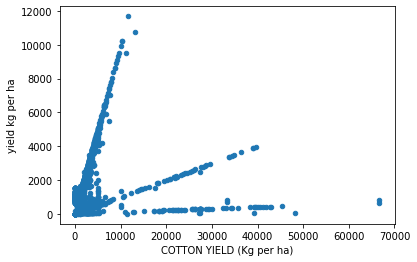

In [204]:
i_train.plot(x ='COTTON YIELD (Kg per ha)', y ='yield kg per ha', kind ='scatter')

By inspection, the gradients of these lines are all (close to) factors of 10.<br>

This gives two problems that any model needs to deal with:
1. The 'error' needs to be accounted for in the model development and training - the model is likely to be best trained with this error 'corrected' in some way 
2.  The 'error' is a human element - it would be expected in the reported data i.e. the prediction needs to report the prediction with error, which may need to be introduced if the model is created to predict using 'corrected' data.

Guided by the US data, which shows typical yields having a range of 200 to 1200 kg per ha, we can introduce a feature that classifies the reported yield; if this classification is made as an appropriate numeric value, then it has the potential to be used by a model to account for the 'error'

In [205]:
i_train2 = india_train.copy()
i_train2 = i_train2.astype(dtype = 'float', errors='ignore')

class_thresh = 1.2  # becomes a tunable parameter
i_train2['type']=0
i_train2['type'] = np.where(i_train2['COTTON YIELD (Kg per ha)']>10*class_thresh, 10, i_train2['type'])
i_train2['type'] = np.where(i_train2['COTTON YIELD (Kg per ha)']>100*class_thresh, 100, i_train2['type'])
i_train2['type'] = np.where(i_train2['COTTON YIELD (Kg per ha)']>1000*class_thresh, 1000, i_train2['type'])
i_train2['type'] = np.where(i_train2['COTTON YIELD (Kg per ha)']>10000*class_thresh, 10000, i_train2['type'])

The errors 'type' are inconsistent within each State/District. To account for this when doing precictions, some means of mapping the best value for the 'type' column is required. The below function uses the mode of type per district, or the mean if there are two modes.

In [206]:
def yield_mode(x):
    '''expresses yield as mode or average if there are two modes'''
    mode_val = x['type'].mode()
    if len(mode_val.values)<2:
        x['type'] = x['type'].mode().values[0]
    else:
        x['type'] = mode_val.values.mean()
    return x

i_train2 = i_train2[i_train2['COTTON PRODUCTION (1000 tons)']>0] # don't want the non-production rows influencing this function
yield_study = i_train2.groupby('Dist Name').apply(yield_mode)
yield_map = yield_study[['Dist Name','type']].groupby('Dist Name').mean().to_dict()

### Dealing with Nan values in India data

There are only 25 rows in the traning data that have no NaN values. It is a reasonable assumption that we should replace these in order to get the best dataset to develop a model from.<br>

We are provided with a dataset showing the average 30 year rainfall for each district, so we will start with this.

In [207]:
soil_rainfall.head()

,State Name,Dist Name,SOIL TYPE PERCENT (Percent),Year_Rainfall,JANUARY NORMAL RAINFALL (Millimeters),FEBRUARY NORMAL RAINFALL (Millimeters),MARCH NORMAL RAINFALL (Millimeters),APRIL NORMAL RAINFALL (Millimeters),MAY NORMAL RAINFALL (Millimeters),JUNE NORMAL RAINFALL (Millimeters),JULY NORMAL RAINFALL (Millimeters),AUGUST NORMAL RAINFALL (Millimeters),SEPTEMBER NORMAL RAINFALL (Millimeters),OCTOBER NORMAL RAINFALL (Millimeters),NOVEMBER NORMAL RAINFALL (Millimeters),DECEMBER NORMAL RAINFALL (Millimeters),ANNUAL NORMAL RAINFALL (Millimeters)
0,Chhattisgarh,Durg,LOAMY ALFISOLS - 60% ; USTALF/USTOLLS - 40%,Average 30 years,16,27,19,19,21,200,340,344,212,61,14,4,1277
1,Chhattisgarh,Bastar,LOAMY ALFISOL - 100%,Average 30 years,5,15,17,51,66,212,398,381,246,116,24,4,1535
2,Chhattisgarh,Raipur,USTALF/USTOLLS - 50% ; LOAMY ALFISOLS - 25% ; ...,Average 30 years,12,20,23,15,17,194,392,394,249,62,8,2,1388
3,Chhattisgarh,Bilaspur,USTALF/USTOLLS - 100%,Average 30 years,17,30,22,17,18,191,381,387,194,52,13,5,1327
4,Chhattisgarh,Raigarh,USTALF/USTOLLS - 100%,Average 30 years,18,16,21,8,14,168,475,508,341,57,1,1,1628


If we assume that this table shows the most likely *trend* for the rainfall, then a strategy could be:
1. For each training row identify the location of the NaN value
2. Calculate the total rainfall for the row (the NaN values will be seen as zero)
3. Find the appropriate row in the average rainfall table
4. Calculate the sum of the average rainfall values, excluding the same values as in the training data
5. Substitue for NaN from the average rainfall data, multiplying the value by the ratio of the two sums

This should give a substitute value that is consistent with the overall trand, but still repects the overall rainfall seen in that year

In [208]:
def subst_nan_rainfall_alt(frame):
    rain_frame = frame.copy()

    soil_rainfall_map = soil_rainfall.copy()

    soil_rainfall_map = soil_rainfall_map.drop(['State Name','SOIL TYPE PERCENT (Percent)','Year_Rainfall'], axis = 1).set_index('Dist Name')
    soil_rain_cols = soil_rainfall_map.columns[4:-1]
    i_rain_cols = rain_frame.columns[6:18]

    # subset of training set with nan for precipitation
    rain_subset = rain_frame[rain_frame.loc[:,i_rain_cols].isnull().values.sum(axis=1).astype('bool')].loc[:,'Dist Name':'DECEMBER PERCIPITATION (Millimeters)']
    rain_subset = rain_subset.drop(['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','COTTON YIELD (Kg per ha)'],axis=1)
    rain_subset['sum'] = rain_subset.loc[:,'JANUARY PERCIPITATION (Millimeters)':].sum(axis=1)
    #rain_subset['sum'] = np.where(rain_subset['sum'].isnull(), 1, rain_subset['sum'])
    ave_rain_map = {x[0]:x[13] for x in soil_rainfall_map.itertuples()}
    rain_subset['ave_rain'] = rain_subset['Dist Name'].map(ave_rain_map)
    rain_subset['ratio'] = rain_subset['sum']/rain_subset['ave_rain']

    col_enum = dict(enumerate(rain_subset.columns))


    # get list of indicies where rainfall data is missing
    # calculate sum of 30 yr data with these indicies missing
    # calculate ratio of the two sums
    # substitute for the missing values, multiplying by the ratio above
    monitor =[]
    for i in rain_subset.index:
        nan_index = []
        try:
            nan_index = list(locate(rain_subset.loc[i,'JANUARY PERCIPITATION (Millimeters)':], lambda x: np.isnan(x)))

        except:
            pass
        
        ave_map_nan_sum =      soil_rainfall_map.loc[rain_subset.loc[i,'Dist Name'],:][nan_index].sum()
        ave_map_sum = soil_rainfall_map.loc[rain_subset.loc[i,'Dist Name'],'ANNUAL NORMAL RAINFALL (Millimeters)']
        ave_map_sum_less_nan = soil_rainfall_map.loc[rain_subset.loc[i,'Dist Name'],'ANNUAL NORMAL RAINFALL (Millimeters)'] - ave_map_nan_sum
        monitor.append(ave_map_nan_sum)
        ratio = rain_subset.loc[i,'sum'] / ave_map_sum_less_nan 
        #nan_index = [x+1 for x in nan_index]
        for item in nan_index:
            subst_val = soil_rainfall_map.loc[rain_subset.loc[i,'Dist Name'],:][item]
            rain_subset.loc[i, col_enum[item+1]] = subst_val * ratio 


    return rain_subset

subst_nan_rainfall_alt(i_train)

,Dist Name,JANUARY PERCIPITATION (Millimeters),FEBRUARY PERCIPITATION (Millimeters),MARCH PERCIPITATION (Millimeters),APRIL PERCIPITATION (Millimeters),MAY PERCIPITATION (Millimeters),JUNE PERCIPITATION (Millimeters),JULY PERCIPITATION (Millimeters),AUGUST PERCIPITATION (Millimeters),SEPTEMBER PERCIPITATION (Millimeters),OCTOBER PERCIPITATION (Millimeters),NOVEMBER PERCIPITATION (Millimeters),DECEMBER PERCIPITATION (Millimeters),sum,ave_rain,ratio
1,Visakhapatnam,10.97561,54.030000,94.67,12.21,143.97,115.080000,167.310000,338.300000,198.25,316.530000,46.86,30.560000,1517.77,975,1.556687
2,East Godavari,3.28000,39.900000,68.64,8.12,207.71,131.980000,168.960000,279.250000,197.16,278.650000,41.65,19.924977,1425.30,1088,1.310018
3,West Godavari,4.14000,43.940000,48.83,5.39,230.23,146.550000,304.561368,276.900000,186.57,216.590000,29.18,18.540000,1206.86,1062,1.136403
4,Krishna,1.18000,15.963075,32.47,2.26,236.77,100.035272,127.990000,199.730000,174.79,194.320000,37.99,9.880000,1017.38,1065,0.955286
8,Chittoor,9.21000,7.730000,19.78,11.15,141.84,31.160000,53.780000,74.010000,132.65,188.274182,80.11,40.830545,561.42,697,0.805481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4694,Murshidabad,0.00000,3.590000,9.58,47.38,97.79,132.020000,256.633850,253.490000,288.42,110.310000,9.68,1.200000,953.46,1391,0.685449
4697,Bankura,0.00000,0.000000,16.44,26.98,98.92,134.140000,384.410000,331.939981,344.16,78.250000,8.99,0.000000,1092.29,1373,0.795550
4698,Hooghly,0.00000,21.590944,5.68,39.57,99.67,117.640000,408.300000,290.540000,421.06,102.670000,15.91,0.000000,1501.04,1622,0.925425
4700,Jalpaiguri,0.00000,8.680000,48.92,284.72,427.76,584.620000,688.040000,484.800000,444.49,101.250000,32.71,2.751098,3105.99,3390,0.916221


The function below was my first attempt at filling in the rainfall NaN values. It contains an error, but using it gave a better result than using the corrected (above) function

In [209]:
def subst_nan_rainfall(frame):
    rain_frame = frame.copy()

    soil_rainfall_map = soil_rainfall.copy()

    soil_rainfall_map = soil_rainfall_map.drop(['State Name','SOIL TYPE PERCENT (Percent)','Year_Rainfall'], axis = 1).set_index('Dist Name')
    soil_rain_cols = soil_rainfall_map.columns[4:-1]
    i_rain_cols = rain_frame.columns[6:18]

    # subset of training set with nan for precipitation
    rain_subset = rain_frame[rain_frame.loc[:,i_rain_cols].isnull().values.sum(axis=1).astype('bool')].loc[:,'Dist Name':'DECEMBER PERCIPITATION (Millimeters)']
    rain_subset = rain_subset.drop(['COTTON AREA (1000 ha)','COTTON PRODUCTION (1000 tons)','COTTON YIELD (Kg per ha)'],axis=1)
    rain_subset['sum'] = rain_subset.loc[:,'JANUARY PERCIPITATION (Millimeters)':].sum(axis=1)
    rain_subset['sum'] = np.where(rain_subset['sum'].isnull(), 1, rain_subset['sum'])
    ave_rain_map = {x[0]:x[13] for x in soil_rainfall_map.itertuples()}
    rain_subset['ave_rain'] = rain_subset['Dist Name'].map(ave_rain_map)
    rain_subset['ratio'] = rain_subset['sum']/rain_subset['ave_rain']

    col_enum = dict(enumerate(rain_subset.columns))

    for i in rain_subset.index:
        for j in range(0,11):  ## crude way of making sure we can handle more than one nan in a row
            try:
                index_nan = np.argmax(rain_subset.loc[i,:].isnull())
                subst_val = soil_rainfall_map.loc[rain_subset.loc[i,'Dist Name'],:][np.argmax(rain_subset.loc[i,:].isnull())-1]
                ratio = rain_subset.loc[i,'ratio']
                rain_subset.loc[i, col_enum[index_nan]] = subst_val * ratio 
            except:
                pass

    return rain_subset

Now look at temperatures

In [210]:
temp_cols_min = ['Year', 'State Name', 'Dist Name','JANUARY MINIMUM (Centigrate)',
       'FEBRUARY MINIMUM (Centigrate)',
       'MARCH MINIMUM (Centigrate)', 'APRIL MINIMUM (Centigrate)',
       'MAY MINIMUM (Centigrate)', 'JUNE MINIMUM (Centigrate)',
       'JULY MINIMUM (Centigrate)', 'AUGUST MINIMUM (Centigrate)',
       'SEPTEMBER MINIMUM (Centigrate)', 'OCTOBER MINIMUM (Centigrate)',
       'NOVEMBER MINIMUM (Centigrate)', 'DECEMBER MINIMUM (Centigrate)',
]
temp_cols_max = ['Year', 'State Name', 'Dist Name',
       'JANUARY MAXIMUM (Centigrate)', 'FEBRUARY MAXIMUM (Centigrate)',
       'MARCH MAXIMUM (Centigrate)', 'APRIL MAXIMUM (Centigrate)',
       'MAY MAXIMUM (Centigrate)', 'JUNE MAXIMUM (Centigrate)',
       'JULY MAXIMUM (Centigrate)', 'AUGUST MAXIMUM (Centigrate)',
       'SEPTEMBER MAXIMUM (Centigrate)', 'OCTOBER MAXIMUM (Centigrate)',
       'NOVEMBER MAXIMUM (Centigrate)', 'DECEMBER MAXIMUM (Centigrate)']
temp_subset_min = i_train[temp_cols_min]

In [211]:
i_train.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)']

,JANUARY MINIMUM (Centigrate),FEBRUARY MINIMUM (Centigrate),MARCH MINIMUM (Centigrate),APRIL MINIMUM (Centigrate),MAY MINIMUM (Centigrate),JUNE MINIMUM (Centigrate),JULY MINIMUM (Centigrate),AUGUST MINIMUM (Centigrate),SEPTEMBER MINIMUM (Centigrate),OCTOBER MINIMUM (Centigrate),NOVEMBER MINIMUM (Centigrate),DECEMBER MINIMUM (Centigrate)
0,20.50,22.70,27.11,29.64,29.24,28.38,26.31,29.71,28.53,25.52,23.10,20.77
1,17.11,19.16,21.37,26.56,23.87,27.06,24.27,23.67,23.67,23.76,22.59,18.99
2,21.34,23.55,NaN,27.93,26.25,28.28,25.81,25.98,27.97,25.37,21.98,21.07
3,21.02,23.89,23.17,26.57,25.82,29.05,26.62,26.72,28.69,24.28,24.74,22.09
4,22.27,21.52,NaN,29.09,27.30,26.43,27.73,25.93,27.04,24.47,23.66,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4700,12.73,18.71,20.33,25.29,25.63,28.84,29.19,27.15,27.94,26.33,20.91,16.62
4701,12.85,17.00,18.39,19.76,24.06,24.56,23.95,26.64,25.43,22.91,16.40,12.37
4702,11.75,19.03,20.49,23.44,27.34,28.09,30.36,28.47,26.98,24.31,NaN,14.88
4703,15.42,19.46,22.14,25.35,26.35,29.39,27.32,30.46,26.52,23.77,20.93,NaN


I used a simple linear interpolation along the row axis for this, repeating the last value if the Jan or Dec value was NaN. This could be improved by using the previous and subsequent year values to interpolate with, but I did not feel the extra complexity worth it at this stage - possibly something to consider later

In [212]:
i_train.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')

,JANUARY MINIMUM (Centigrate),FEBRUARY MINIMUM (Centigrate),MARCH MINIMUM (Centigrate),APRIL MINIMUM (Centigrate),MAY MINIMUM (Centigrate),JUNE MINIMUM (Centigrate),JULY MINIMUM (Centigrate),AUGUST MINIMUM (Centigrate),SEPTEMBER MINIMUM (Centigrate),OCTOBER MINIMUM (Centigrate),NOVEMBER MINIMUM (Centigrate),DECEMBER MINIMUM (Centigrate)
0,20.50,22.70,27.110,29.640,29.24,28.38,26.31,29.71,28.53,25.52,23.100,20.77
1,17.11,19.16,21.370,26.560,23.87,27.06,24.27,23.67,23.67,23.76,22.590,18.99
2,21.34,23.55,25.740,27.930,26.25,28.28,25.81,25.98,27.97,25.37,21.980,21.07
3,21.02,23.89,23.170,26.570,25.82,29.05,26.62,26.72,28.69,24.28,24.740,22.09
4,22.27,21.52,25.305,29.090,27.30,26.43,27.73,25.93,27.04,24.47,23.660,23.66
...,...,...,...,...,...,...,...,...,...,...,...,...
4700,12.73,18.71,20.330,25.290,25.63,28.84,29.19,27.15,27.94,26.33,20.910,16.62
4701,12.85,17.00,18.390,19.760,24.06,24.56,23.95,26.64,25.43,22.91,16.400,12.37
4702,11.75,19.03,20.490,23.440,27.34,28.09,30.36,28.47,26.98,24.31,19.595,14.88
4703,15.42,19.46,22.140,25.350,26.35,29.39,27.32,30.46,26.52,23.77,20.930,20.93


For all other NaN values I used a simple strategy of replacing with the mean value for the grouped district - I did not immediately see a better way of doing this

In [213]:
## fill na with average value by district
def mean_fill(frame):
    districts = frame[['State Name','Dist Name']]
    frame = frame.drop(['State Name'], axis = 1)
    frame = frame.groupby('Dist Name').transform(lambda x: x.fillna(x.mean()))
    frame[['State Name','Dist Name']] = districts
    frame = frame.replace([np.inf, -np.inf], np.nan).fillna(0)
    return frame

## Baseline model - XGBoost

Note that this is in the form that delivers the best overall result. Many of the substitution functions for NaN are not used for the tree based model.

In [214]:
itrain = india_train.copy()
itrain = itrain.astype(dtype = 'float', errors='ignore')

itrain['yield_factor'] = itrain['Dist Name'].map(yield_map['type'])

# dont allow negative areas or production values - replace with NaN 
itrain['COTTON AREA (1000 ha)'] = np.where(itrain['COTTON AREA (1000 ha)']<0, np.nan, itrain['COTTON AREA (1000 ha)'])
itrain['COTTON PRODUCTION (1000 tons)'] = np.where(itrain['COTTON PRODUCTION (1000 tons)']<0,0,itrain['COTTON PRODUCTION (1000 tons)'])

# replace temperature NaN
# itrain.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'] = itrain.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')
# itrain.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'] = itrain.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')

# replace rainfall NaN
subst_rain = subst_nan_rainfall(itrain)
# subst_rain = subst_nan_rainfall_alt(itrain)
itrain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)'] = subst_rain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)']

# replace all remaining NaN with means grouped by district
# itrain = mean_fill(itrain)



Two methods of splitting data for training. These were used during model development to help understand if there were any time related trends that needed to be considered. These are often problematic for tree based regressors.

In [215]:
def split_random(frame):
    X1 = frame.copy()
    X1 = X1.drop(['Year',
    'State Name',
    'Dist Name',
    #'COTTON AREA (1000 ha)',
    #'COTTON PRODUCTION (1000 tons)'
    ], axis = 1)
    #X = X1.fillna(0)
    X = X1.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    y = X1['COTTON YIELD (Kg per ha)']

    X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
    return X_train, X_val , y_train, y_val, X, y

def split_years(frame):
    X1 = frame.copy()
    cutoff = 2002
    X1_train  = X1[X1['Year']<=cutoff]
    X1_val  = X1[X1['Year']>cutoff]
    drop_list = ['Year',
    'State Name',
    'Dist Name',
    #'COTTON AREA (1000 ha)',
    #'COTTON PRODUCTION (1000 tons)'
    ]
    X_train = X1_train.drop(drop_list, axis = 1)
    X_val= X1_val.drop(drop_list, axis = 1)
    X_train = X_train.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    X_val = X_val.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    #X = X1.fillna(0)
    y_train = X1_train['COTTON YIELD (Kg per ha)']
    y_val = X1_val['COTTON YIELD (Kg per ha)']

    X = X1.drop(drop_list, axis = 1)
    X = X.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    y = X1['COTTON YIELD (Kg per ha)']

    return X_train, X_val , y_train, y_val, X, y

In [216]:

X_train, X_val , y_train, y_val, X, y = split_random(itrain)

model = XGBRegressor(seed=42,objective='reg:squarederror', booster = 'dart', rate_drop = 0.1, skip_drop = 0.2)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

Validation MSE: 1623.5015526421744


In [217]:
## Use to find best parameters, commented out as these are reproduced in the cell below

# from sklearn.model_selection import RandomizedSearchCV
# model_opt = XGBRegressor(objective='reg:squarederror',seed = 42, booster = 'dart', rate_drop = 0.1, skip_drop = 0.2)
# params = dict(n_estimators = (50,60,70,80,90,100,110,130,150),
#               max_depth= (3,7,11,13,15,17,19,21), 
#               colsample_bylevel = (0.1, 0.3, 0.5, 0.7,0.9,1), 
#               learning_rate = (0.3,0.5,0.7,0,9,1), 
#               alpha = (0, 0.3, 0.5, 0.7, 0.9, 1), 
#               gamma = (0, 0.3, 0.5, 0.7, 0.9, 1)
#               )
# clf = RandomizedSearchCV(model_opt, params, random_state=42,scoring = 'neg_mean_squared_error', n_jobs=-1)
# search = clf.fit(X,y)
# search.best_params_


In [218]:
params_dart = {'n_estimators': 110,
 'max_depth': 15,
 'learning_rate': 0.3,
 'gamma': 0.5,
 'colsample_bylevel': 0.5,
 'alpha': 0.5}
model = XGBRegressor(objective='reg:squarederror',seed = 42, booster = 'dart', rate_drop = 0.1, skip_drop = 0.2, **params_dart)

In [219]:
#model = search.best_estimator_   ## this is not as good on test set as training on x_train split
#model = XGBRegressor(objective='reg:squarederror',seed = 42, **params_dart)
model.fit(X_train, y_train)
#model.fit(X,y)
model_tree = model
y_pred_val = model.predict(X_val)
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

Validation MSE: 1747.5521704881103


Now run this on test data

In [220]:
# now try on test set
india_test_frame= india_test.copy()

india_test_frame['yield_factor'] = india_test_frame['Dist Name'].map(yield_map['type'])

# replace rainfall NaN
subst_rain = subst_nan_rainfall(india_test_frame)
# subst_rain = subst_nan_rainfall_alt(india_test_frame)
india_test_frame.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)'] = subst_rain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)']

# dont allow negative areas or production values - replace with NaN 
india_test_frame['COTTON AREA (1000 ha)'] = np.where(india_test_frame['COTTON AREA (1000 ha)']<0, np.nan, india_test_frame['COTTON AREA (1000 ha)'])
india_test_frame['COTTON PRODUCTION (1000 tons)'] = np.where(india_test_frame['COTTON PRODUCTION (1000 tons)']<0,0,india_test_frame['COTTON PRODUCTION (1000 tons)'])

# # replace temperature NaN
# india_test_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'] = india_test_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')
# india_test_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'] = india_test_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')


# # replace all remaining NaN with means grouped by district
# india_test_frame = mean_fill(india_test_frame)


In [140]:
X1 = india_test_frame.copy()
X1 = X1.drop(['Year',
'State Name',
'Dist Name',
], axis = 1)
X = X1.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
y = X1['COTTON YIELD (Kg per ha)']
y_pred_val = model.predict(X)
india_test_frame['yield'] = y_pred_val


# best estimator is the division of production and area, where available
india_test_frame['calc yield'] = india_test_frame['COTTON PRODUCTION (1000 tons)']*1000 / india_test_frame['COTTON AREA (1000 ha)']
india_test_frame['calc yield'] = india_test_frame['calc yield'].replace([np.inf, -np.inf], np.nan)

# we can't accept negative predictions
india_test_frame['yield'] = np.where(india_test_frame['COTTON PRODUCTION (1000 tons)']<=0,0, india_test_frame['yield'])
india_test_frame['yield'] = np.where(india_test_frame['yield']<0,0, india_test_frame['yield'])

# now 'correct' for the human decimal point 'problem'
india_test_frame['calc yield factor']=1
india_test_frame['calc yield factor'] = np.where(india_test_frame['calc yield']>10, 10, india_test_frame['calc yield factor'])
india_test_frame['calc yield factor'] = np.where(india_test_frame['calc yield']>100, 100, india_test_frame['calc yield factor'])
india_test_frame['calc yield factor'] = np.where(india_test_frame['calc yield']>1000, 1000, india_test_frame['calc yield factor'])
india_test_frame['calc yield factor'] = np.where(india_test_frame['calc yield']>10000, 10000, india_test_frame['calc yield factor'])
india_test_frame['COTTON YIELD (Kg per ha)'] = np.where(india_test_frame['calc yield'].isna(),
                                                          india_test_frame['yield'],
                                                           india_test_frame['calc yield']*(india_test_frame['yield_factor']/india_test_frame['calc yield factor']) )

india_test_frame['COTTON YIELD (Kg per ha)'] = np.where(india_test_frame['COTTON YIELD (Kg per ha)']<0,0,india_test_frame['COTTON YIELD (Kg per ha)'])
india_test_frame['COTTON YIELD (Kg per ha)'] = np.where(india_test_frame['COTTON YIELD (Kg per ha)'].isnull(),0,india_test_frame['COTTON YIELD (Kg per ha)'])

In [141]:
india_check = india_test.copy()
#india_check['yield'] = y_pred_val
india_check['yield'] = india_test_frame['COTTON YIELD (Kg per ha)']
india_check['COTTON YIELD (Kg per ha)'] = india_check['COTTON PRODUCTION (1000 tons)']*1000 / india_check['COTTON AREA (1000 ha)']
india_check['COTTON YIELD (Kg per ha)'] = india_check['COTTON YIELD (Kg per ha)'].replace([np.inf, -np.inf], np.nan)

<AxesSubplot:xlabel='COTTON YIELD (Kg per ha)', ylabel='yield'>

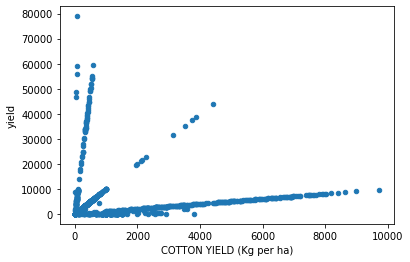

In [142]:
india_check['yield'] = np.where(india_check['COTTON PRODUCTION (1000 tons)']<=0, 0, india_check['yield'])
india_check['yield'] = np.where(india_check['COTTON AREA (1000 ha)']<=0, 0, india_check['yield'])
india_check.plot(x = 'COTTON YIELD (Kg per ha)', y='yield', kind = 'scatter')

(0.0, 100.0)

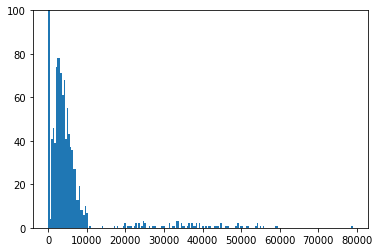

In [143]:
india_submission = india_check['yield']

_ = plt.hist(india_submission, bins = 200)
ax = plt.gca()
ax.set_ylim(0,100)

(0.0, 80000.0)

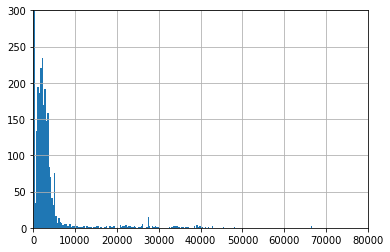

In [144]:
i_train['COTTON YIELD (Kg per ha)'].hist(bins = 200)
ax = plt.gca()
ax.set_ylim(0,300)
ax.set_xlim(0,80000)

## Not really happy with these results, despite leading to good score on the test dataset

I tried training a simple deep learning model that should have been able to take advantage of any underlying relationships in the data, but this did not produce better scores. I've only included it here for information. I also developed a stacked model, with a tree model on top of a deep learning model, without success, but have not included this. 

In [145]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#from sklearn.model_selection import train_test_split
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

In [146]:
train_nn = india_train.copy()

train_nn['yield_factor']=0
train_nn['yield_factor'] = np.where(train_nn['COTTON YIELD (Kg per ha)']>10*class_thresh, 10, train_nn['yield_factor'])
train_nn['yield_factor'] = np.where(train_nn['COTTON YIELD (Kg per ha)']>100*class_thresh, 100, train_nn['yield_factor'])
train_nn['yield_factor'] = np.where(train_nn['COTTON YIELD (Kg per ha)']>1000*class_thresh, 1000, train_nn['yield_factor'])
train_nn['yield_factor'] = np.where(train_nn['COTTON YIELD (Kg per ha)']>10000*class_thresh, 10000, train_nn['yield_factor'])

#train_nn['yield_factor'] = train_nn['Dist Name'].map(yield_map['type'])

# dont allow negative areas or production values - replace with NaN 
train_nn['COTTON AREA (1000 ha)'] = np.where(train_nn['COTTON AREA (1000 ha)']<0, np.nan, train_nn['COTTON AREA (1000 ha)'])
train_nn['COTTON PRODUCTION (1000 tons)'] = np.where(train_nn['COTTON PRODUCTION (1000 tons)']<0,0,train_nn['COTTON PRODUCTION (1000 tons)'])

# replace temperature NaN
train_nn.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'] = train_nn.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')
train_nn.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'] = train_nn.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')

# replace rainfall NaN
subst_rain = subst_nan_rainfall_alt(train_nn)
train_nn.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)'] = subst_rain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)']

# replace all remaining NaN with means grouped by district
train_nn = mean_fill(train_nn)



In [147]:
tf.keras.backend.clear_session()  ## to stop excessive memory use when running model multiple times


def split_random_nn(frame):
    X1 = frame.copy()
    drop_list = [
    'State Name',
    'Dist Name',
    #'COTTON AREA (1000 ha)',
    #'COTTON PRODUCTION (1000 tons)'
    ]
    X_train_nn = X1.drop(drop_list, axis = 1)
    X_train_nn = frame.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    X_train_nn = X_train_nn.drop(['State Name', 'Dist Name'], axis = 1)
    y_train_nn = train_nn['COTTON YIELD (Kg per ha)']
    nn_X_train, nn_X_val, nn_y_train, nn_y_val = train_test_split(X_train_nn, y_train_nn, test_size=0.1, random_state=42)
    
    return nn_X_train, nn_X_val, nn_y_train, nn_y_val

def split_years_nn(frame):
    X1 = frame.copy()
    cutoff =1999
    X1_train  = X1[X1['Year']<=cutoff]
    X1_val  = X1[X1['Year']>cutoff]
    drop_list = [
    'State Name',
    'Dist Name',
    #'COTTON AREA (1000 ha)',
    #'COTTON PRODUCTION (1000 tons)'
    ]
    X_train = X1_train.drop(drop_list, axis = 1)
    X_val= X1_val.drop(drop_list, axis = 1)
    X_train = X_train.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    X_val = X_val.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    #X = X1.fillna(0)
    y_train = X1_train['COTTON YIELD (Kg per ha)']
    y_val = X1_val['COTTON YIELD (Kg per ha)']

    X = X1.drop(drop_list, axis = 1)
    X = X.drop(['COTTON YIELD (Kg per ha)'], axis = 1)
    y = X1['COTTON YIELD (Kg per ha)']

    return X_train, X_val , y_train, y_val




nn_X_train, nn_X_val, nn_y_train, nn_y_val = split_years_nn(train_nn)

X_train_nn = train_nn.drop(['Dist Name','State Name', 'COTTON YIELD (Kg per ha)'], axis = 1)
y_train_nn = train_nn['COTTON YIELD (Kg per ha)']

In [148]:
def modelx(X_train):

    shape=(len(X_train.columns))

    inputs=tf.keras.Input(shape=shape)

    x = tf.keras.layers.Dense(100, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # x = tf.keras.layers.Dense(100, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.1)(x)
    # x = tf.keras.layers.Dense(10, activation='relu')(x)

  
    out=tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [149]:
scaler=MinMaxScaler((0,1))
cols = nn_X_train.columns
X_train_norm=pd.DataFrame(scaler.fit_transform(nn_X_train.fillna(0)), columns=cols)
X_val_norm =pd.DataFrame(scaler.transform(nn_X_val.fillna(0)), columns=cols)

In [150]:
model_nn=modelx(X_train_norm)
#model=model4(X_train, X_train_clouds)
model_nn.summary()
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=1000,
    decay_rate=0.8)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01)

model_nn.compile(optimizer=optimizer,
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.MeanSquaredError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=70,
                                            restore_best_weights=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 101)]             0         
                                                                 
 dense (Dense)               (None, 100)               10200     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0     

In [151]:
history = model_nn.fit(X_train_norm, nn_y_train, epochs=900, batch_size=32, validation_data=(X_val_norm, nn_y_val), callbacks=callback, verbose=2)

Epoch 1/900
87/87 - 2s - loss: 22850658.0000 - mean_squared_error: 22850658.0000 - val_loss: 23750482.0000 - val_mean_squared_error: 23750482.0000 - 2s/epoch - 26ms/step
Epoch 2/900
87/87 - 1s - loss: 18165028.0000 - mean_squared_error: 18165028.0000 - val_loss: 9897827.0000 - val_mean_squared_error: 9897827.0000 - 1s/epoch - 17ms/step
Epoch 3/900
87/87 - 1s - loss: 8473497.0000 - mean_squared_error: 8473497.0000 - val_loss: 5051813.0000 - val_mean_squared_error: 5051813.0000 - 772ms/epoch - 9ms/step
Epoch 4/900
87/87 - 1s - loss: 6518104.0000 - mean_squared_error: 6518104.0000 - val_loss: 5403976.0000 - val_mean_squared_error: 5403976.0000 - 769ms/epoch - 9ms/step
Epoch 5/900
87/87 - 1s - loss: 5158502.0000 - mean_squared_error: 5158502.0000 - val_loss: 8432361.0000 - val_mean_squared_error: 8432361.0000 - 824ms/epoch - 9ms/step
Epoch 6/900
87/87 - 1s - loss: 5809306.0000 - mean_squared_error: 5809306.0000 - val_loss: 6744943.5000 - val_mean_squared_error: 6744943.5000 - 894ms/epoch -

In [152]:
y_preds = model_nn.predict(X_val_norm)
mse = np.sqrt(mean_squared_error(y_preds, nn_y_val))
print(f"Validation MSE: {mse}")

61/61 [==============================] - 0s 3ms/step
Validation MSE: 1757.965986075695


In [153]:
y_pred_full = model_nn.predict(scaler.transform(X_train_nn))

148/148 [==============================] - 1s 3ms/step


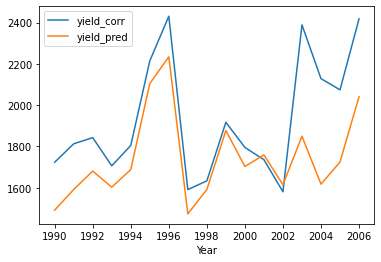

In [154]:
# assemble data to view results as plot
train_nn_plot = X_train_nn.copy()
train_nn_plot['yield_corr'] = y_train_nn
train_nn_plot['yield_pred'] = y_pred_full
_=train_nn_plot.groupby('Year')[['yield_corr','yield_pred']].mean().plot()

In [165]:
# now set up pipeline for this to predict on raw data

pred_frame = india_train.copy()

pred_frame = pred_frame.astype(dtype = 'float', errors='ignore')

pred_frame['yield_factor']=1
pred_frame['yield_factor'] = np.where(pred_frame['COTTON YIELD (Kg per ha)']>10*class_thresh, 10, pred_frame['yield_factor'])
pred_frame['yield_factor'] = np.where(pred_frame['COTTON YIELD (Kg per ha)']>100*class_thresh, 100, pred_frame['yield_factor'])
pred_frame['yield_factor'] = np.where(pred_frame['COTTON YIELD (Kg per ha)']>1000*class_thresh, 1000, pred_frame['yield_factor'])
pred_frame['yield_factor'] = np.where(pred_frame['COTTON YIELD (Kg per ha)']>10000*class_thresh, 10000, pred_frame['yield_factor'])


#pred_frame['yield_factor'] = pred_frame['Dist Name'].map(yield_map['type'])

# dont allow negative areas or production values - replace with NaN 
pred_frame['COTTON AREA (1000 ha)'] = np.where(pred_frame['COTTON AREA (1000 ha)']<0, np.nan, pred_frame['COTTON AREA (1000 ha)'])
pred_frame['COTTON PRODUCTION (1000 tons)'] = np.where(pred_frame['COTTON PRODUCTION (1000 tons)']<0,0,pred_frame['COTTON PRODUCTION (1000 tons)'])

# replace temperature NaN
pred_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'] = pred_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')
pred_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'] = pred_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')

# replace rainfall NaN
subst_rain = subst_nan_rainfall_alt(pred_frame)
pred_frame.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)'] = subst_rain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)']

# replace all remaining NaN with means grouped by district
pred_frame = mean_fill(pred_frame)


#remove any -ve values and replace with np.nan
# names = pred_frame[['State Name', 'Dist Name']]
# pred_frame = pred_frame.drop(['State Name', 'Dist Name'], axis = 1)
# pred_frame[pred_frame<0]=np.nan
# pred_frame[['State Name', 'Dist Name']] = names

X_pred_full = pred_frame.drop(['Dist Name','State Name', 'COTTON YIELD (Kg per ha)'], axis = 1)

y_pred_full = model_nn.predict(scaler.transform(X_pred_full))

148/148 [==============================] - 1s 5ms/step


In [166]:
pred_frame['yield_pred'] = y_pred_full

In [181]:
# pred_frame['calc yield'] = pred_frame['COTTON PRODUCTION (1000 tons)']*1000 / pred_frame['COTTON AREA (1000 ha)']
# pred_frame['calc yield'] = pred_frame['calc yield'].replace([np.inf, -np.inf], np.nan)
#pred_frame['yield_adj'] = np.where(pred_frame['COTTON PRODUCTION (1000 tons)']<=0,0, pred_frame['yield_pred'])

pred_frame['yield_corr'] = pred_frame['COTTON YIELD (Kg per ha)'] / pred_frame['yield_factor'] *1000

class_thresh = 1
pred_frame['calc yield factor']=1
pred_frame['calc yield factor'] = np.where(pred_frame['yield_pred']>10*class_thresh, 10, pred_frame['calc yield factor'])
pred_frame['calc yield factor'] = np.where(pred_frame['yield_pred']>100*class_thresh, 100, pred_frame['calc yield factor'])
pred_frame['calc yield factor'] = np.where(pred_frame['yield_pred']>1000*class_thresh, 1000, pred_frame['calc yield factor'])
pred_frame['calc yield factor'] = np.where(pred_frame['yield_pred']>10000*class_thresh, 10000, pred_frame['calc yield factor'])

pred_frame['yield_adj'] =   pred_frame['yield_pred']*pred_frame['yield_factor']/pred_frame['calc yield factor']
pred_frame['yield_adj'] = np.where(pred_frame['COTTON PRODUCTION (1000 tons)']<=0,0, pred_frame['yield_adj'])
pred_frame['yield_adj'] = np.where(pred_frame['COTTON AREA (1000 ha)']<=0,0, pred_frame['yield_adj'])
pred_frame['yield_pred'] = np.where(pred_frame['COTTON AREA (1000 ha)']<=0,0, pred_frame['yield_pred'])

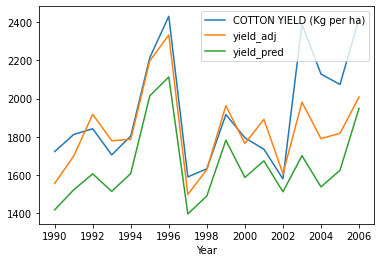

In [182]:
pred_frame.groupby('Year')[['COTTON YIELD (Kg per ha)','yield_adj','yield_pred']].mean().plot()
ax = plt.gca()
#ax.set_ylim(0,)

Now try this on test data

In [169]:
# now set up pipeline for this to predict on raw data

test_frame = india_test.copy()

test_frame = test_frame.astype(dtype = 'float', errors='ignore')



test_frame['yield_factor'] = test_frame['Dist Name'].map(yield_map['type'])
test_frame['yield_corr'] = test_frame['COTTON YIELD (Kg per ha)'] / test_frame['yield_factor'] *100

# dont allow negative areas or production values - replace with NaN 
test_frame['COTTON AREA (1000 ha)'] = np.where(test_frame['COTTON AREA (1000 ha)']<0, np.nan, test_frame['COTTON AREA (1000 ha)'])
test_frame['COTTON PRODUCTION (1000 tons)'] = np.where(test_frame['COTTON PRODUCTION (1000 tons)']<0,0,test_frame['COTTON PRODUCTION (1000 tons)'])

# replace temperature NaN
test_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'] = test_frame.loc[:,'JANUARY MINIMUM (Centigrate)':'DECEMBER MINIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')
test_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'] = test_frame.loc[:,'JANUARY MAXIMUM (Centigrate)':'DECEMBER MAXIMUM (Centigrate)'].interpolate(method='linear', axis=1, limit_direction='both')

# # replace rainfall NaN
subst_rain = subst_nan_rainfall_alt(test_frame)
test_frame.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)'] = subst_rain.loc[:,'JANUARY PERCIPITATION (Millimeters)':'DECEMBER PERCIPITATION (Millimeters)']



# replace all remaining NaN with means grouped by district
test_frame = mean_fill(test_frame)

#remove any -ve values and replace with 0
names = test_frame[['State Name', 'Dist Name']]
test_frame = test_frame.drop(['State Name', 'Dist Name'], axis = 1)
test_frame[test_frame<0]= 0
test_frame[['State Name', 'Dist Name']] = names

X_test_full = test_frame.drop(['Dist Name','State Name', 'COTTON YIELD (Kg per ha)','yield_corr'], axis = 1)

y_test_full = model_nn.predict(scaler.transform(X_test_full))

78/78 [==============================] - 0s 5ms/step


In [170]:
#test_frame['yield_pred'] = y_test_full
test_frame['yield'] = y_test_full

In [171]:
# test_frame['calc yield factor']=1
# test_frame['calc yield factor'] = np.where(test_frame['yield_pred']>10, 10, test_frame['calc yield factor'])
# test_frame['calc yield factor'] = np.where(test_frame['yield_pred']>100, 100, test_frame['calc yield factor'])
# test_frame['calc yield factor'] = np.where(test_frame['yield_pred']>1000, 1000, test_frame['calc yield factor'])
# test_frame['calc yield factor'] = np.where(test_frame['yield_pred']>10000, 10000, test_frame['calc yield factor'])
# #test_frame['yield_adj'] =   test_frame['yield_pred']*(test_frame['type']/test_frame['calc yield factor']) 
# test_frame['yield_adj'] =   test_frame['yield_pred']*test_frame['yield_factor']/test_frame['calc yield factor']
# test_frame['yield_adj'] = np.where(test_frame['COTTON PRODUCTION (1000 tons)']<=0,0, test_frame['yield_adj'])
# test_frame['yield_adj'] = np.where(test_frame['COTTON AREA (1000 ha)']<=0,0, test_frame['yield_adj'])
# test_frame['yield_pred'] = np.where(test_frame['COTTON AREA (1000 ha)']<=0,0, test_frame['yield_pred'])

In [192]:
# best estimator is the division of production and area, where available
test_frame['calc yield'] = test_frame['COTTON PRODUCTION (1000 tons)']*1000 / test_frame['COTTON AREA (1000 ha)']
test_frame['calc yield'] = test_frame['calc yield'].replace([np.inf, -np.inf], np.nan)

# we can't accept negative predictions
test_frame['yield'] = np.where(test_frame['COTTON PRODUCTION (1000 tons)']<=0,0, test_frame['yield'])
test_frame['yield'] = np.where(test_frame['yield']<0,0, test_frame['yield'])

# now 'correct' for the human decimal point 'problem'
test_frame['calc yield factor']=0
class_thresh = 1
test_frame['calc yield factor'] = np.where(test_frame['calc yield']>10*class_thresh, 10, test_frame['calc yield factor'])
test_frame['calc yield factor'] = np.where(test_frame['calc yield']>100*class_thresh, 100, test_frame['calc yield factor'])
test_frame['calc yield factor'] = np.where(test_frame['calc yield']>1000*class_thresh, 1000, test_frame['calc yield factor'])
test_frame['calc yield factor'] = np.where(test_frame['calc yield']>10000*class_thresh, 10000, test_frame['calc yield factor'])
test_frame['COTTON YIELD (Kg per ha)'] = np.where(test_frame['calc yield'].isna(),
                                                          test_frame['yield'],
                                                           test_frame['calc yield']*(test_frame['yield_factor']/test_frame['calc yield factor']) )

test_frame['COTTON YIELD (Kg per ha)']=test_frame['COTTON YIELD (Kg per ha)'].replace([np.inf, -np.inf],np.nan).fillna(0)
test_frame['COTTON YIELD (Kg per ha)'] = np.where(test_frame['COTTON YIELD (Kg per ha)']<0,0,test_frame['COTTON YIELD (Kg per ha)'])
test_frame['COTTON YIELD (Kg per ha)'] = np.where(test_frame['COTTON YIELD (Kg per ha)'].isnull(),0,test_frame['COTTON YIELD (Kg per ha)'])

(0.0, 3167.224212615564)

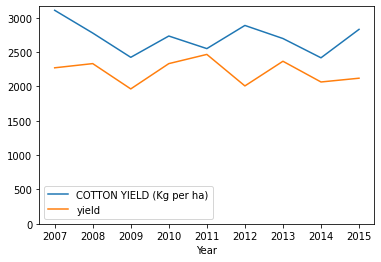

In [193]:
test_frame.groupby('Year')[['COTTON YIELD (Kg per ha)','yield']].mean().plot()
ax = plt.gca()
ax.set_ylim(0,)

<AxesSubplot:xlabel='Year'>

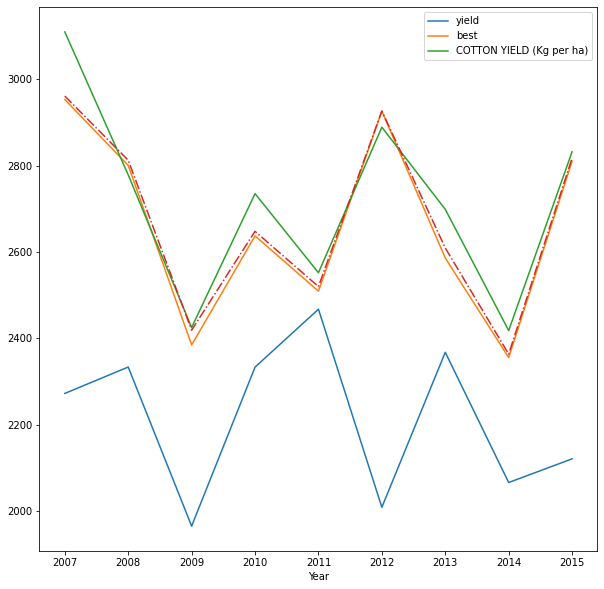

In [194]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
test1 = pd.read_csv('submission94.csv')
test_frame['best']  =  test1['COTTON YIELD (Kg per ha)']
test_frame.groupby('Year')[['yield','best','COTTON YIELD (Kg per ha)']].mean().plot(ax=ax)

india_test_frame.groupby('Year')['COTTON YIELD (Kg per ha)'].mean().plot(ax=ax, linestyle = '-.')

In [104]:
india_submission = test_frame['COTTON YIELD (Kg per ha)']

## Now look at US model

Check similar XGBoost approach on US data

In [69]:
## set baseline  - Years  out of range should not fit well
X = u_train.copy()
high_states = ['CA', 'AZ']
X['State'] = np.where(X['State'].isin(high_states), 1,0)

X=X.fillna(0)
X=X.drop(['State',
    'yield kg per ha', 
    ], axis=1)
y = X['Yield (Pounds/ Harvested Area)']
X = X.drop('Yield (Pounds/ Harvested Area)', axis = 1)


X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
model = XGBRegressor(seed = 42, objective='reg:squarederror', booster = 'dart', rate_drop = 0.1, skip_drop = 0)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

Validation MSE: 130.58475800755087


In [70]:
from sklearn.model_selection import RandomizedSearchCV
us_model = XGBRegressor(objective='reg:squarederror',seed = 42)
params = dict(n_estimators = (50,60,70,80,90,100,110,130,150),
              max_depth= (3,7,11,13,15,17,19,21), 
              colsample_bylevel = (0.1, 0.3, 0.5, 0.7,0.9,1), 
              learning_rate = (0.3,0.5,0.7,0,9,1), 
              alpha = (0, 0.3, 0.5, 0.7, 0.9, 1), 
              gamma = (0, 0.3, 0.5, 0.7, 0.9, 1))
us_clf = RandomizedSearchCV(us_model, params, random_state=42,scoring = 'neg_mean_squared_error', n_jobs=-1)
search = us_clf.fit(X, y)
search.best_params_

c:\Python310\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [-392385.125       -76417.58448586              nan  -25455.47535062
 -392385.125                   nan  -24559.7745138  -392385.125
  -27478.85010885  -37004.03269909]
  warnings.warn(


{'n_estimators': 110,
 'max_depth': 15,
 'learning_rate': 0.3,
 'gamma': 0.5,
 'colsample_bylevel': 0.5,
 'alpha': 0.5}

In [71]:
us_model = us_clf.best_estimator_
us_clf.best_score_

-24559.774513802236

In [72]:
y_preds = us_model.predict(X)
# Calculate the MSE)
mse = np.sqrt(mean_squared_error(u_train['Yield (Pounds/ Harvested Area)'], y_preds))
print(f"Validation MSE: {mse}")

Validation MSE: 0.20616381475616274


C:\Users\steve\AppData\Local\Temp\ipykernel_24244\271496312.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp.groupby('Year')['Yield (Pounds/ Harvested Area)', 'yield'].mean().plot()


<AxesSubplot:xlabel='Year'>

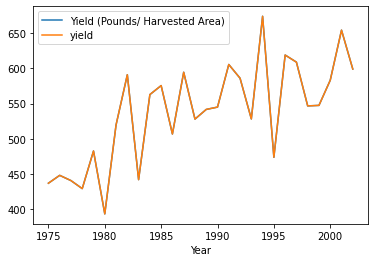

In [73]:
temp = u_train.copy()
temp['State'] = np.where(temp['State'].isin(high_states), 1,0)
temp = temp.fillna(0)
temp['yield'] = us_model.predict(temp.drop(['Yield (Pounds/ Harvested Area)', 'yield kg per ha', 'State'],axis =1))
temp.groupby('Year')['Yield (Pounds/ Harvested Area)', 'yield'].mean().plot()

This model, whilst looking to fit well, does not work if we split the dataset by time

In [74]:
## set baseline  - test train spit at 1995
X = u_train.copy()
high_states = ['CA', 'AZ']
X['State'] = np.where(X['State'].isin(high_states), 1,0)
X=X.fillna(0)
X=X.drop([

    'yield kg per ha', 
    ], axis=1)
cutoff = 1990
train = X[X.Year<cutoff]
test = X[X['Year']>=cutoff]

# train = train.drop('Year', axis = 1)
# test = test.drop('Year', axis = 1)

y_train = train['Yield (Pounds/ Harvested Area)']
X_train = train.drop('Yield (Pounds/ Harvested Area)', axis = 1)

y_val = test['Yield (Pounds/ Harvested Area)']
X_val = test.drop('Yield (Pounds/ Harvested Area)', axis = 1)

X = X.drop(['Yield (Pounds/ Harvested Area)','Year'], axis = 1)

#X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
model = XGBRegressor(seed = 42, objective='reg:squarederror', booster = 'dart', rate_drop = 0.1, skip_drop = 0)
model.fit(X_train.drop('Year', axis = 1), y_train)
y_pred_val = model.predict(X_val.drop('Year', axis = 1))
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

Validation MSE: 168.55391593654699


C:\Users\steve\AppData\Local\Temp\ipykernel_24244\1023687477.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp.groupby('Year')['Yield (Pounds/ Harvested Area)', 'yield'].mean().plot()


<AxesSubplot:xlabel='Year'>

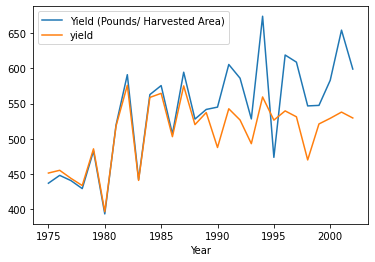

In [75]:
temp = u_train.copy()
temp['State'] = np.where(temp['State'].isin(high_states), 1,0)
temp = temp.fillna(0)
temp['yield'] = model.predict(temp.drop(['Yield (Pounds/ Harvested Area)','yield kg per ha','Year'],axis =1))
temp.groupby('Year')['Yield (Pounds/ Harvested Area)', 'yield'].mean().plot()

Let's build a simple NN to see if this deals with dates better

In [76]:
## Don't run this if you want to compare NN with XGBoost regressor with test/train split at specified year
X = u_train.copy()
high_states = ['CA', 'AZ']
X['State'] = np.where(X['State'].isin(high_states), 1,0)
X=X.fillna(0)
X=X.drop([
    'yield kg per ha', 
    ], axis=1)
y = X['Yield (Pounds/ Harvested Area)']
X = X.drop('Yield (Pounds/ Harvested Area)', axis = 1)


X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)
model = XGBRegressor(seed = 42, objective='reg:squarederror', booster = 'gblinear')
model.fit(X_train, y_train)
y_pred_val = model.predict(X_val)
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

Validation MSE: 218.25407644282086


In [77]:
seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

In [78]:
def modelx(X_train):
    '''linear model - should be best linear fit'''
    shape=(len(X_train.columns))

    inputs=tf.keras.Input(shape=shape)

    x = tf.keras.layers.Dense(100, activation='relu')(inputs)
    x = tf.keras.layers.Dropout(.2)(x)
    #x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    # # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(100, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.1)(x)
    # x = tf.keras.layers.Dense(50, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.1)(x)
    # x = tf.keras.layers.Dense(10, activation='relu')(x)

  
    out=tf.keras.layers.Dense(1, activation='linear')(x)
    model = tf.keras.Model(inputs=inputs, outputs=out)

    return model

In [79]:
scaler=MinMaxScaler((0,1))
cols = X_train.columns
X_train_norm=pd.DataFrame(scaler.fit_transform(X_train.fillna(0)), columns=cols)
X_val_norm =pd.DataFrame(scaler.transform(X_val.fillna(0)), columns=cols)
model_nn=modelx(X_train_norm)
#model=model4(X_train, X_train_clouds)
model_nn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 dense_4 (Dense)             (None, 100)               2500      
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dropout_4 (Dropout)         (None, 100)               0         
                                                                 
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0   

In [80]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=750,
    decay_rate=0.5)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# optimizer=tf.keras.optimizers.Adam(
#     learning_rate=0.01)

model_nn.compile(optimizer=optimizer,
             loss='mean_squared_error',
             metrics=[tf.keras.metrics.MeanSquaredError()])

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=120,
                                            restore_best_weights=True)

In [81]:
history = model_nn.fit(X_train_norm, y_train, epochs=900, batch_size=32, validation_data=(X_val_norm, y_val), callbacks=callback, verbose=2)

Epoch 1/900


16/16 - 2s - loss: 268539.7812 - mean_squared_error: 268539.7812 - val_loss: 81822.4141 - val_mean_squared_error: 81822.4141 - 2s/epoch - 128ms/step
Epoch 2/900
16/16 - 0s - loss: 105515.8125 - mean_squared_error: 105515.8125 - val_loss: 76974.0000 - val_mean_squared_error: 76974.0000 - 138ms/epoch - 9ms/step
Epoch 3/900
16/16 - 0s - loss: 93012.8828 - mean_squared_error: 93012.8828 - val_loss: 62632.3242 - val_mean_squared_error: 62632.3242 - 142ms/epoch - 9ms/step
Epoch 4/900
16/16 - 0s - loss: 78704.3672 - mean_squared_error: 78704.3672 - val_loss: 54416.8477 - val_mean_squared_error: 54416.8477 - 138ms/epoch - 9ms/step
Epoch 5/900
16/16 - 0s - loss: 66784.6094 - mean_squared_error: 66784.6094 - val_loss: 49992.9453 - val_mean_squared_error: 49992.9453 - 131ms/epoch - 8ms/step
Epoch 6/900
16/16 - 0s - loss: 57602.2695 - mean_squared_error: 57602.2695 - val_loss: 48809.6602 - val_mean_squared_error: 48809.6602 - 166ms/epoch - 10ms/step
Epoch 7/900
16/16 - 0s - loss: 58314.1875 - mean

In [82]:
y_preds = model_nn.predict(X_val_norm)
mse = np.sqrt(mean_squared_error(y_preds, y_val))
print(f"Validation MSE: {mse}")

2/2 [==============================] - 0s 4ms/step
Validation MSE: 188.33703982626128


18/18 [==============================] - 0s 3ms/step


<AxesSubplot:xlabel='Year'>

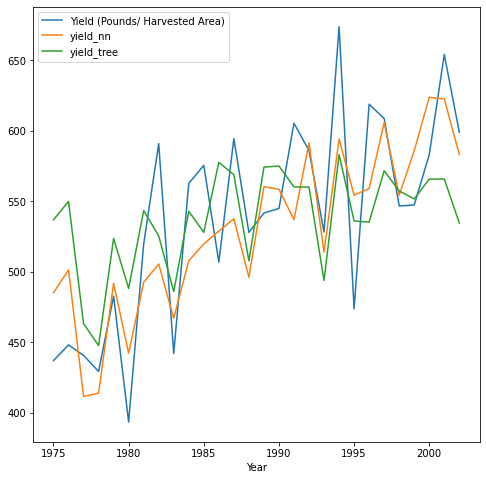

In [83]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
temp = u_train.copy()
high_states = ['CA', 'AZ']
temp['State'] = np.where(temp['State'].isin(high_states), 1,0)
temp['yield_nn'] = model_nn.predict(scaler.transform(temp.drop(['Yield (Pounds/ Harvested Area)',  'yield kg per ha'],axis =1).fillna(0)))
temp['yield_tree'] = model.predict(temp.drop(['Yield (Pounds/ Harvested Area)',  'yield kg per ha', 'yield_nn'],axis =1).fillna(0))
temp.groupby('Year')[['Yield (Pounds/ Harvested Area)', 'yield_nn', 'yield_tree']].mean().plot(ax=ax)

### Create the US submission

In [84]:
# using nn 
X = u_test.copy()

X['State'] = X['State'].fillna('NA')

X['State'] = np.where(X.State.isin(['CA','AZ']),1,0)

#X=X.drop([ 'production 1000 tonnes'], axis=1)

X = X.drop(['Yield (Pounds/ Harvested Area)'], axis = 1)
X = X.fillna(0)
X = scaler.transform(X)

us_preds = model_nn.predict(X)
us_preds = np.where(us_preds<10, 0, us_preds)

temp = u_test.copy()
temp['Yield (Pounds/ Harvested Area)'] = us_preds
temp['Yield (Pounds/ Harvested Area)'] = np.where(temp['Harvested (1000 Acres)']<=0,0,temp['Yield (Pounds/ Harvested Area)'])

us_preds = temp['Yield (Pounds/ Harvested Area)']

 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 3ms/step


Take a look at the distributions. From the trend data, it would be expected that the US yields would increase over time. This seems to be the case, and the distribution looks reasonable too.

(0.0, 30.0)

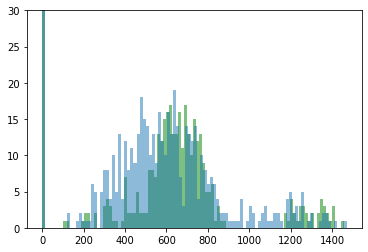

In [85]:
plt.hist(us_preds, bins = 100, alpha = 0.5, color = 'g')
plt.hist(u_train['Yield (Pounds/ Harvested Area)'], bins = 100, alpha = 0.5)
ax = plt.gca()
ax.set_ylim(0,30)

<AxesSubplot:xlabel='State', ylabel='Yield (Pounds/ Harvested Area)'>

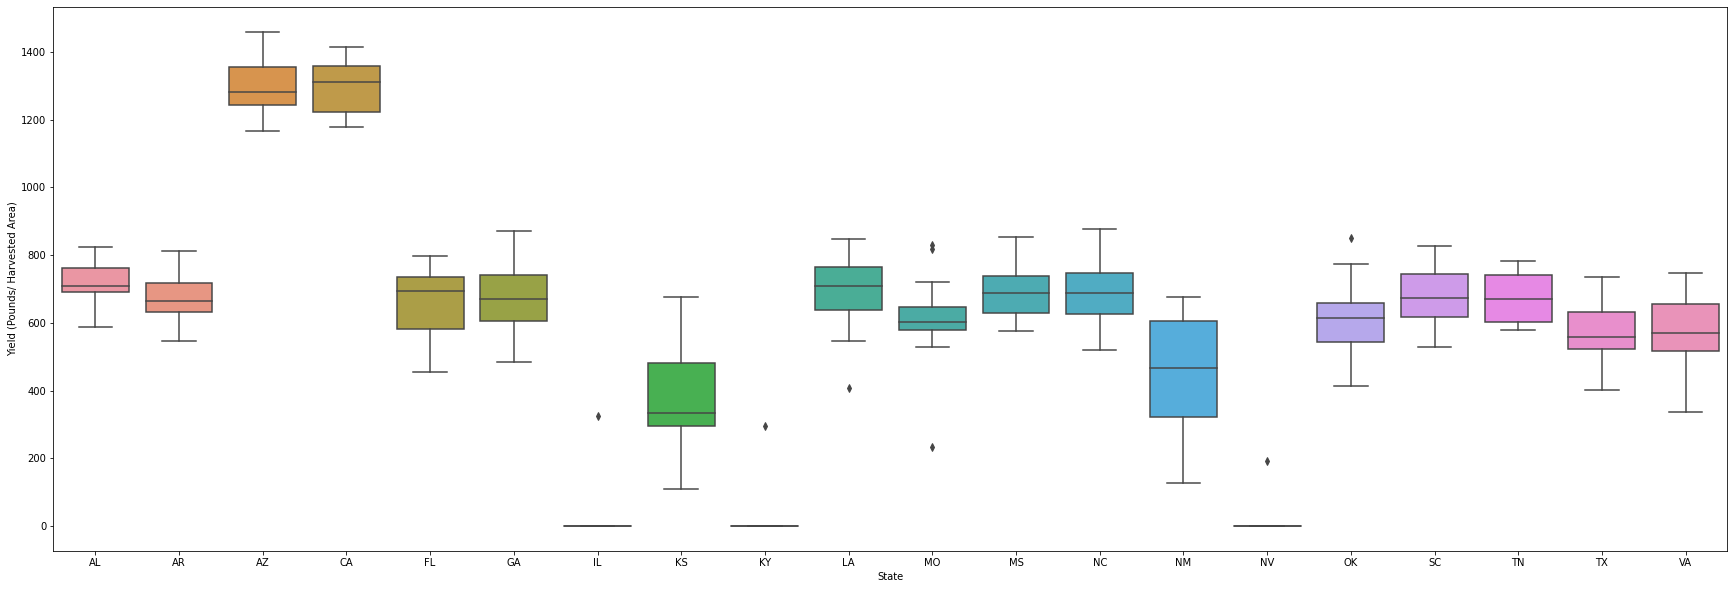

In [86]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
sns.boxplot(data = temp, x = 'State', y = 'Yield (Pounds/ Harvested Area)')

## Now look at stock price

A reasonable expectation would be that the stock price would be a function of both production quantity and yield: Yield becasuse that should relate to the cost of production;  quantity as this should relate to price, through the normal balance of supply and demand.<br>

There is also likely to be a second order relationship to the level of stocks that are kept. There is no data available on this, but it would be reasonable to think that it should be related to the prior year's production quantity, or more likely, the difference between this year and last year's production quantity (as this is what makes the overall stock go up and down if demand is constant).

Inspection of the date ranges for the data also suggests that only be the US production data that can be used to estimate the price i.e. there has to be an assumption that there is no influence from imports to the US on the US price

Let's build a model along these assumptions

In [87]:
# Assemble pricing dataframe - prices, yields and total production
u_pricing = usa_train.copy()
def prepare_common_us(frame):
    frame['Planted (1000 Acres)']= frame['Planted (1000 Acres)'].str.replace(',','').astype('float')
    frame['Harvested (1000 Acres)']= frame['Harvested (1000 Acres)'].str.replace(',','').astype('float')
    frame['production_kg'] = frame['Harvested (1000 Acres)']*frame['Yield (Pounds/ Harvested Area)'] / 2.2046  *1000
    frame['area_ha'] = frame['Harvested (1000 Acres)'] * 0.404686 *1000
    frame['yield_kg_ha'] = frame['Yield (Pounds/ Harvested Area)'] / 2.2046 / 0.404686
    return frame


def us_pricing_agg(x):
    return pd.Series([x['production_kg'].sum() / x['area_ha'].sum(), x['production_kg'].sum()/10e6], index = ['u_yield_kg_ha', 'u_production_KT'])

u_pricing = prepare_common_us(u_pricing)

pricing = u_pricing.groupby('Year').apply(us_pricing_agg).reset_index()
pricing = pricing.merge(commodity, left_on='Year', right_on='Year')



In [88]:
pricing

,Year,u_yield_kg_ha,u_production_KT,Cotton_Price[Dollar/ton]
0,1975,510.970806,180.542003,1055.792518
1,1976,523.588629,230.302141,1582.035312
2,1977,583.815946,289.775515,1399.933700
3,1978,473.412714,236.107502,1350.109288
4,1979,615.205876,317.206568,1428.152836
5,1980,452.989296,240.935408,1869.517760
6,1981,611.300371,340.970335,1697.116476
7,1982,662.384210,252.188606,1446.892106
8,1983,568.992253,167.723714,1655.008234
9,1984,674.882780,281.309081,1604.963360


To get to a more complete pricing dataset, we need to create columns that show the changes from prior year for yield and quantity (if they are not found to be important, the models should ignore them or give them a low weight)

In [89]:
pricing_slip1 = pricing.copy()
pricing_slip1['u_production_KT_diff'] = pricing_slip1['u_production_KT'].diff(1)
pricing_slip1['u_yield_kg_ha_diff'] = pricing_slip1['u_yield_kg_ha'].diff(1)
#pricing_slip1['cum_sum_prod_diff'] = pricing_slip1['u_production_KT_diff'].cumsum()
pricing_slip1['price'] = pricing_slip1['Cotton_Price[Dollar/ton]'].shift(1)
pricing_slip1

,Year,u_yield_kg_ha,u_production_KT,Cotton_Price[Dollar/ton],u_production_KT_diff,u_yield_kg_ha_diff,price
0,1975,510.970806,180.542003,1055.792518,NaN,NaN,NaN
1,1976,523.588629,230.302141,1582.035312,49.760138,12.617823,1055.792518
2,1977,583.815946,289.775515,1399.933700,59.473374,60.227317,1582.035312
3,1978,473.412714,236.107502,1350.109288,-53.668012,-110.403232,1399.933700
4,1979,615.205876,317.206568,1428.152836,81.099066,141.793162,1350.109288
5,1980,452.989296,240.935408,1869.517760,-76.271160,-162.216580,1428.152836
6,1981,611.300371,340.970335,1697.116476,100.034927,158.311075,1869.517760
7,1982,662.384210,252.188606,1446.892106,-88.781729,51.083839,1697.116476
8,1983,568.992253,167.723714,1655.008234,-84.464892,-93.391957,1446.892106
9,1984,674.882780,281.309081,1604.963360,113.585367,105.890527,1655.008234


Lets try a simple linear regressor and an XGBoost regressor

In [90]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
# reg.fit(X.iloc[:,:], y)
# print(reg.intercept_, reg.coef_)

In [91]:
X1 = pricing_slip1.copy()
X1 = X1.dropna()
X = X1.drop(['Cotton_Price[Dollar/ton]'], axis = 1)
y = X1['Cotton_Price[Dollar/ton]']
X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
price_model = XGBRegressor(seed=42)
price_model.fit(X_train, y_train)
y_pred_val = price_model.predict(X_val)
# Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

reg2 = linear_model.LinearRegression()
reg2.fit(X.iloc[:,:], y)
print(reg2.intercept_, reg2.coef_)

Validation MSE: 263.93607258621614
20105.929296676775 [-9.76117966 -0.16524945  0.47595888  0.05133645 -0.37238609  0.5070458 ]


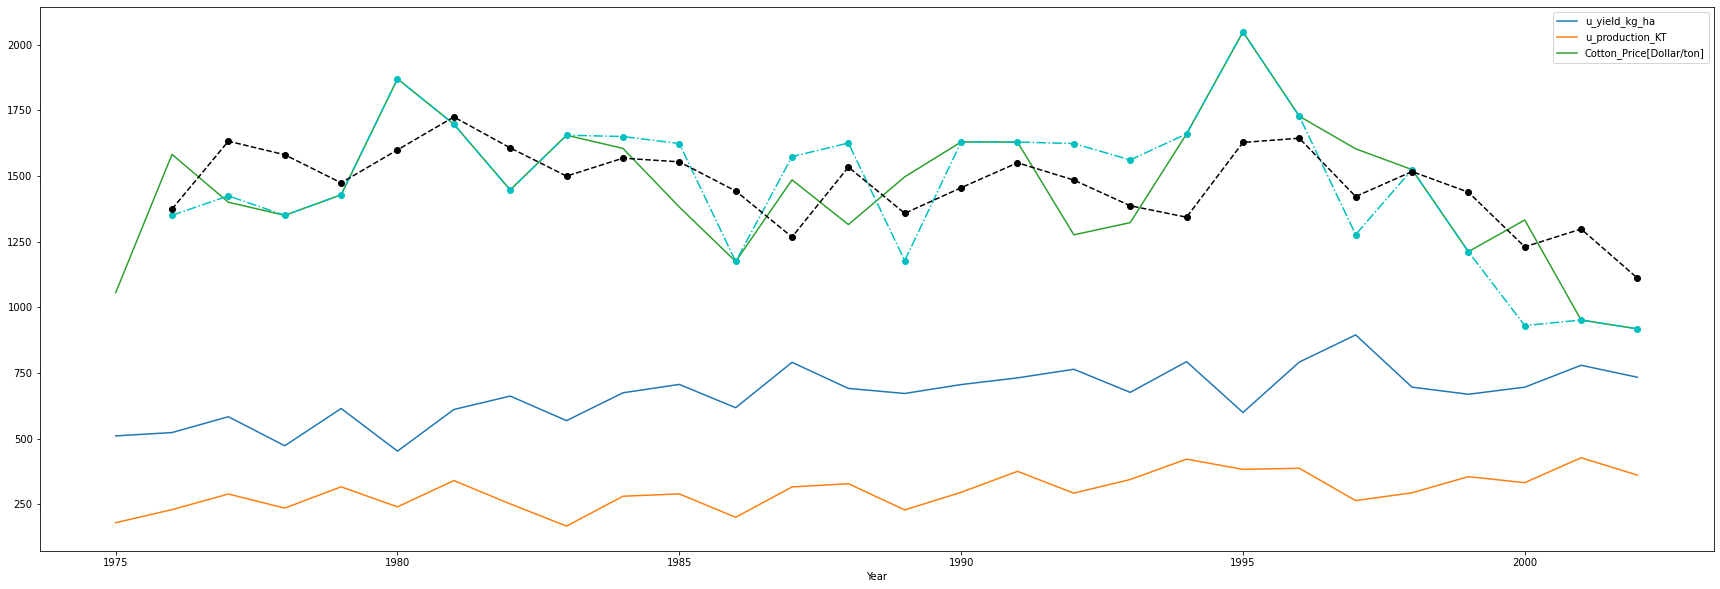

In [92]:
fig, ax = plt.subplots(1,1, figsize = (30,10))
pricing.plot(x = 'Year', ax=ax)
ax.plot(X1['Year'], price_model.predict(X), marker = 'o', linestyle='-.', color = 'c')
ax.plot(X1['Year'], (X.iloc[:,:] * reg2.coef_[:]).sum(axis = 1) + reg2.intercept_, marker = 'o', linestyle='--', color = 'k')

They both look to fit well, but what if we split the data at 1990? Prior data is the training set and later data is for validation. This does not look so good for the XGBoost regressor, but the simple linear regressor performs very well

In [93]:
X1 = pricing_slip1.copy()
X1 = X1.dropna()
X = X1.drop(['Cotton_Price[Dollar/ton]'], axis = 1)
y = X1['Cotton_Price[Dollar/ton]']

cutoff = 1990

y_train  = X1[X1['Year']<cutoff]['Cotton_Price[Dollar/ton]']
X_val  = X1[X1['Year']>=cutoff].drop(['Cotton_Price[Dollar/ton]'], axis=1)
y_val  = X1[X1['Year']>=cutoff]['Cotton_Price[Dollar/ton]']
X_train  = X1[X1['Year']<cutoff].drop(['Cotton_Price[Dollar/ton]'], axis=1)

# #X_train, X_val , y_train, y_val = train_test_split(X, y, test_size=0.4, random_state=42)
price_model = XGBRegressor(seed=42)
price_model.fit(X_train, y_train)
y_pred_val = price_model.predict(X_val)
# # Calculate the MSE
mse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"Validation MSE: {mse}")

reg2 = linear_model.LinearRegression()
reg2.fit(X.iloc[:,:], y)
print(reg2.intercept_, reg2.coef_)

Validation MSE: 323.09163337010136
20105.929296676775 [-9.76117966 -0.16524945  0.47595888  0.05133645 -0.37238609  0.5070458 ]


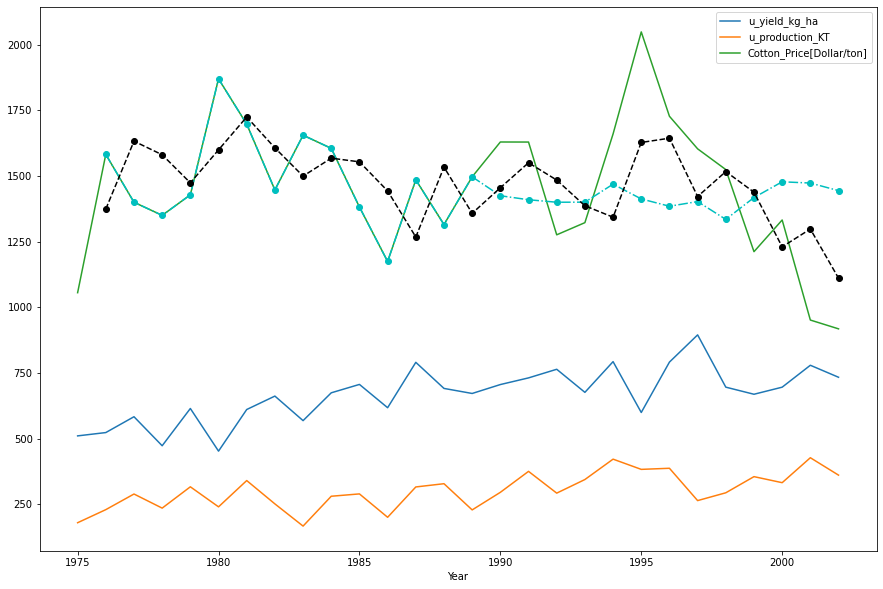

In [94]:
fig, ax = plt.subplots(1,1, figsize = (15,10))
pricing.plot(x = 'Year', ax=ax)
ax.plot(X1['Year'], price_model.predict(X), marker = 'o', linestyle='-.', color = 'c')
ax.plot(X1['Year'], (X.iloc[:,:] * reg2.coef_[:]).sum(axis = 1) + reg2.intercept_, marker = 'o', linestyle='--', color = 'k')

### Now use the US forecast data to predict the new pricing dataframe

Create the pricing dataframe as before. This time we need to use the last data from the training set to give the price for the first line (year 2002). 

In [95]:
u_pricing_pred = usa_test.copy()
u_pricing_pred['Yield (Pounds/ Harvested Area)'] = us_preds

u_pricing_pred = prepare_common_us(u_pricing_pred)

pricing_pred = u_pricing_pred.groupby('Year').apply(us_pricing_agg).reset_index()

In [96]:
pricing_pred_slip1 = pricing_pred.copy()
pricing_pred_slip1.set_index('Year', inplace=True)
pricing_pred_slip1['Cotton_Price[Dollar/ton]'] = 0
pricing_pred_slip1['price'] = 0
pricing_pred_slip1.loc[2002,:] = pricing_slip1.set_index('Year').loc[2002,:]
pricing_pred_slip1 = pricing_pred_slip1.reset_index().sort_values('Year').reset_index(drop=True)
pricing_pred_slip1['u_production_KT_diff'] = pricing_pred_slip1['u_production_KT'].diff(1)
pricing_pred_slip1['u_yield_kg_ha_diff'] = pricing_pred_slip1['u_yield_kg_ha'].diff(1)
#pricing_pred_slip1['cum_sum_prod_diff'] = pricing_pred_slip1['u_production_KT_diff'].cumsum()
#pricing_pred_slip1['price'] = pricing_pred_slip1['Cotton_Price[Dollar/ton]'].shift(1)

pricing_pred_slip1 = pricing_pred_slip1[['Year', 'u_yield_kg_ha', 'u_production_KT', 
       'u_production_KT_diff', 'u_yield_kg_ha_diff','price','Cotton_Price[Dollar/ton]']]
pricing_pred_slip1_XG = pricing_pred_slip1.copy()
pricing_pred_slip1

,Year,u_yield_kg_ha,u_production_KT,u_production_KT_diff,u_yield_kg_ha_diff,price,Cotton_Price[Dollar/ton]
0,2002,734.024077,361.627778,NaN,NaN,951.734454,918.22423
1,2003,679.594638,325.241533,-36.386246,-54.429438,0.000000,0.00000
2,2004,688.914891,340.212576,14.971044,9.320252,0.000000,0.00000
3,2005,766.452205,419.787430,79.574854,77.537314,0.000000,0.00000
4,2006,735.534585,333.022622,-86.764808,-30.917620,0.000000,0.00000
5,2007,748.585639,306.577433,-26.445189,13.051054,0.000000,0.00000
6,2008,708.366156,208.778750,-97.798683,-40.219483,0.000000,0.00000
7,2009,722.231779,216.168136,7.389385,13.865623,0.000000,0.00000
8,2010,681.942898,289.688589,73.520453,-40.288881,0.000000,0.00000
9,2011,701.163803,259.802576,-29.886013,19.220906,0.000000,0.00000


We now need to loop over this dataframe, using the prior year price as an input to the next year's prediction

In [97]:
for i in range(1,len(pricing_pred_slip1_XG)):
    pricing_pred_slip1_XG.loc[i,'price'] = pricing_pred_slip1_XG.loc[i-1,'Cotton_Price[Dollar/ton]']
    pricing_pred_slip1_XG.loc[i,'Cotton_Price[Dollar/ton]'] = price_model.predict(pricing_pred_slip1_XG.iloc[(i-1):i,:-1])

In [98]:
for i in range(1,len(pricing_pred_slip1)):
    pricing_pred_slip1.loc[i,'price'] = pricing_pred_slip1.loc[i-1,'Cotton_Price[Dollar/ton]']
    pricing_pred_slip1.loc[i,'Cotton_Price[Dollar/ton]'] =  reg2.intercept_ + (pricing_pred_slip1.iloc[i,:-1].values * reg2.coef_[:]).sum()

<AxesSubplot:xlabel='Year'>

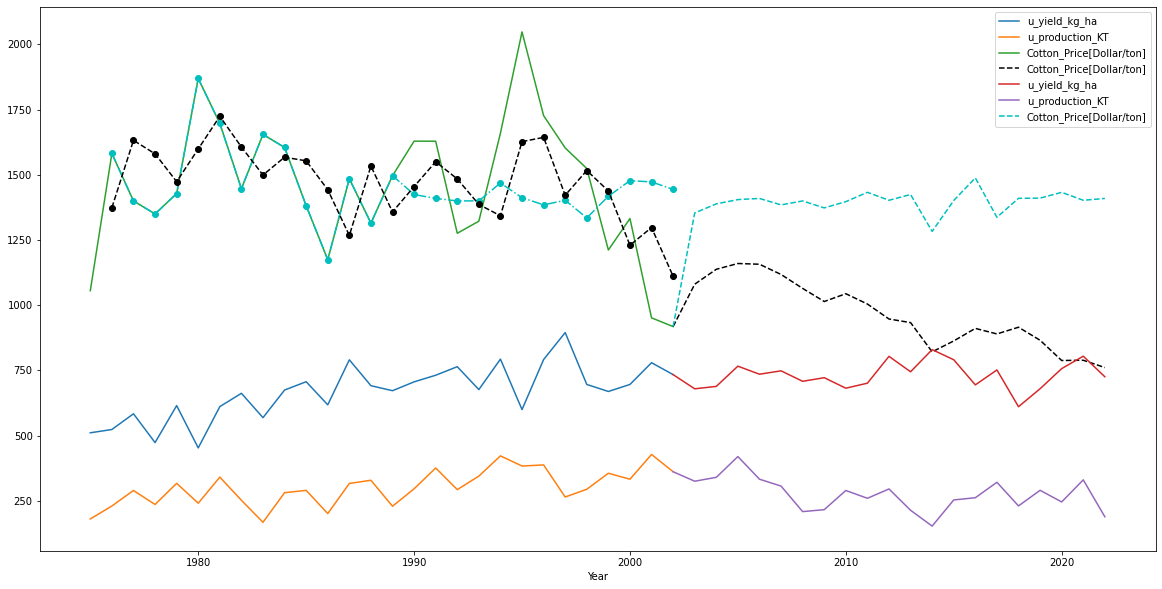

In [99]:
fig, ax = plt.subplots(1,1, figsize = (20,10))
pricing.plot(x = 'Year', ax=ax)
ax.plot(X1['Year'], price_model.predict(X), marker = 'o', linestyle='-.', color = 'c')
ax.plot(X1['Year'], (X.iloc[:,:] * reg2.coef_[:]).sum(axis = 1) + reg2.intercept_, marker = 'o', linestyle='--', color = 'k')
pricing_pred_slip1.plot(x = 'Year', y = 'Cotton_Price[Dollar/ton]', ax=ax, color = 'k', linestyle = '--')
pricing_pred_slip1.plot(x = 'Year', y = 'u_yield_kg_ha', ax=ax)
pricing_pred_slip1.plot(x = 'Year', y = 'u_production_KT', ax=ax)
pricing_pred_slip1_XG.plot(x = 'Year', y = 'Cotton_Price[Dollar/ton]', ax=ax, color = 'c', linestyle = '--')

In [100]:
price_map = dict(zip(pricing_pred_slip1['Year'],pricing_pred_slip1['Cotton_Price[Dollar/ton]']))
price_map

{2002: 918.22423,
 2003: 1080.767961598067,
 2004: 1137.9063367098897,
 2005: 1160.0917360972162,
 2006: 1157.2400296980522,
 2007: 1118.01267481572,
 2008: 1064.633696812638,
 2009: 1014.2921278434114,
 2010: 1044.2172133322383,
 2011: 1004.7595279534253,
 2012: 947.2390154197346,
 2013: 933.4724904124159,
 2014: 821.2720472376059,
 2015: 863.1568694836824,
 2016: 911.2797438810303,
 2017: 889.9759649490115,
 2018: 915.7681495823053,
 2019: 865.7492188709548,
 2020: 788.1741937503502,
 2021: 789.1693501102018,
 2022: 761.0688004386684}

In [105]:
submission = pd.concat([pd.DataFrame(india_submission), pd.DataFrame(us_preds)], axis=1)
submission.columns = (['COTTON YIELD (Kg per ha)','Yield (Pounds/ Harvested Area)'])

submission['Cotton_Price[Dollar/ton]'] = 0
submission.loc[0:399,'Cotton_Price[Dollar/ton]'] = u_test['Year'].map(price_map).values

In [106]:
submission = submission[[ 'Yield (Pounds/ Harvested Area)','COTTON YIELD (Kg per ha)',
       'Cotton_Price[Dollar/ton]']]

In [107]:
submission.fillna(0).to_csv('submission103.csv', index = False)

In [ ]:
25631741.24939
8691596.62530
10283041.96043